In [2]:
using PyPlot;
using Revise;
using MDToolbox;
using StatsBase; # for calculating histogram
using Printf;
using DelimitedFiles;
using Distributions;
using LinearAlgebra;
using GLM;
using DataFrames;
PyPlot.plt[:style][:use]("seaborn-colorblind");
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[2]:11
└ @ Core In[2]:11
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[2]:11
└ @ Core In[2]:11


In [3]:
# setup constants
KBT = KB_kcalpermol*300.0
sigma = 6.0
sigma_matrix = (sigma^2) * Matrix{Float64}(I, 2, 2)

2×2 Array{Float64,2}:
 36.0   0.0
  0.0  36.0

In [4]:
# umbrella window centers
phi_centers = -180:15:-15
psi_centers = 165:-15:0
umbrella_centers_num = length(phi_centers) * length(psi_centers)

umbrella_centers = zeros(Float64, umbrella_centers_num, 2)
umbrella_center_index = 0
for i = 1:length(psi_centers)
    for j = 1:length(phi_centers)
        umbrella_center_index += 1
        umbrella_centers[umbrella_center_index, :] = [phi_centers[i], psi_centers[j]]
    end
end

In [5]:
# define edges for bin
bin_phi_edge = range(-180, stop=0, length=181)
bin_psi_edge = range(180,  stop=0, length=181)

bin_centers = []
for i = 1:length(bin_phi_edge)
    for j = 1:length(bin_psi_edge)
        push!(bin_centers, [bin_phi_edge[i], bin_psi_edge[j]])
    end
end

In [7]:
# read dihedral angle data
data_k = []
for i = 1:umbrella_centers_num
  filename = @sprintf "4_prod/run_%d_%d.dat" umbrella_centers[i, 1] umbrella_centers[i, 2]
  x = readdlm(filename);
  push!(data_k, x[:, 2:3])
end

In [9]:
# ΔWの計算
include("Density.jl")
include("PotentialOfMeanForce.jl")

delta_pmfs = []
for i = 1:umbrella_centers_num
    for j = 1:size(data_k[i], 1)
        push!(delta_pmfs, calc_delta_potential_of_mean_force(umbrella_centers[i, :], data_k[i], sigma_matrix, KBT, data_k[i][j, :]))
    end
end

delta_pmfs

72000-element Array{Any,1}:
 -4.589658356171357   
 -0.21990864944681263 
 -1.03164158950792    
 -1.4913917729720703  
 -1.1976094488833025  
 -2.350726797447373   
 -0.5690983899313833  
 -0.42622105017517753 
 -0.8682432872203139  
 -0.850514581678282   
 -0.617714769894264   
  0.0188376087114049  
 -0.3373409039913674  
  ⋮                   
 -3.1775176086364962  
 -8.223650008869036   
 -3.0732720002110847  
 -2.2797079511830134  
 -1.681660442717333   
 -4.417701405133757   
 -0.035260875360754854
 -1.04272451928645    
 -3.479645319439339   
 -1.8536102272318389  
 -0.8059641719433962  
 -1.2968833515694955  

In [8]:
# 設計行列の計算

include("DesignMatrix.jl")
M = calc_design_matrix(umbrella_centers, data_k, sigma_matrix)

72000×144 Array{Float64,2}:
 -0.932467      -0.043561      -3.72261e-6    -6.1011e-13    …   3.30404e-258   6.84906e-285   2.74079e-314
 -0.068068       0.0235158      5.69818e-6     1.932e-12         3.71505e-269   1.00119e-294   0.0         
 -0.396611      -0.0337309     -3.3934e-6     -5.89187e-13       1.01429e-267   6.38791e-294   0.0         
 -0.524619      -0.0202494     -1.4481e-6     -1.87081e-13       3.74243e-260   6.94333e-286   2.4868e-314 
 -0.46425       -0.0387173     -3.62849e-6    -6.06629e-13       8.50408e-270   3.08478e-296   0.0         
 -0.739785      -0.0429479     -3.7194e-6     -6.10091e-13   …   2.67663e-269   3.78796e-296   0.0         
 -0.235366      -0.0328189     -3.41458e-6    -5.93283e-13       2.4336e-272    1.30974e-298   0.0         
 -0.151394       0.0234372      6.59954e-6     2.44505e-12       2.11465e-266   6.25118e-292   3.57605e-320
 -0.336579      -0.03104       -3.24265e-6    -5.75129e-13       3.80301e-268   2.75272e-294   0.0         


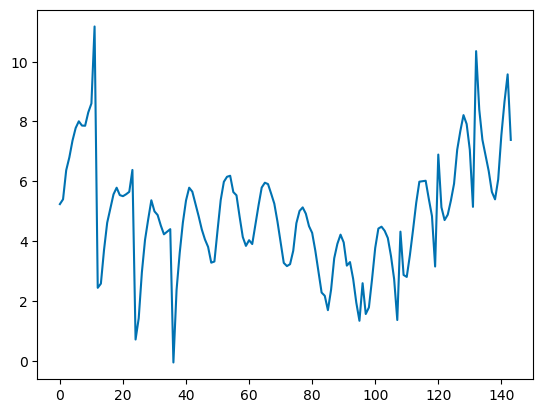

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1c6784be0>

In [12]:
# 最小二乗推定で重みを計算する

U, S, V = svd(M) # 特異値分解
inverse_M = V * inv(Diagonal(S)) * U' # 擬似逆行列
weight = inverse_M * delta_pmfs

plt.plot(weight)

In [14]:
# PMFの計算
include("PotentialOfMeanForce.jl")

pmf = calc_potential_of_mean_force(umbrella_centers, bin_centers, weight, sigma_matrix)
pmf = reshape(pmf, size(bin_phi_edge, 1), size(bin_psi_edge, 1))
pmf = pmf .* KBT
pmf = pmf .- minimum(pmf)

181×181 Array{Float64,2}:
 0.138137  0.137636  0.134024  0.127853  0.11989   0.111012  …  0.0348624  0.0240921  0.0159801  0.0100696
 0.207574  0.206825  0.201421  0.19219   0.180276  0.166994     0.053071   0.0369583  0.0248225  0.0159802
 0.302879  0.301789  0.293927  0.280494  0.263159  0.243832     0.0780622  0.0546171  0.0369587  0.0240925
 0.429425  0.427882  0.416755  0.397743  0.37321   0.345857     0.111244   0.0780634  0.0530723  0.0348636
 0.591834  0.58971   0.574392  0.548221  0.514448  0.476795     0.153826   0.108152   0.073751   0.0486861
 0.793078  0.790233  0.769723  0.734681  0.689461  0.639044  …  0.206585   0.145431   0.0993716  0.0658119
 1.03351   1.0298    1.00309   0.957449  0.898551  0.832886     0.269605   0.189962   0.129975   0.0862687
 1.30996   1.30527   1.27142   1.21359   1.13897   1.05577      0.342046   0.241148   0.165154   0.109783 
 1.61515   1.60937   1.56765   1.49637   1.40438   1.30183      0.421977   0.297628   0.20397    0.13573  
 1.93758   

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[17]:8
└ @ Core In[17]:8
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[17]:9
└ @ Core In[17]:9


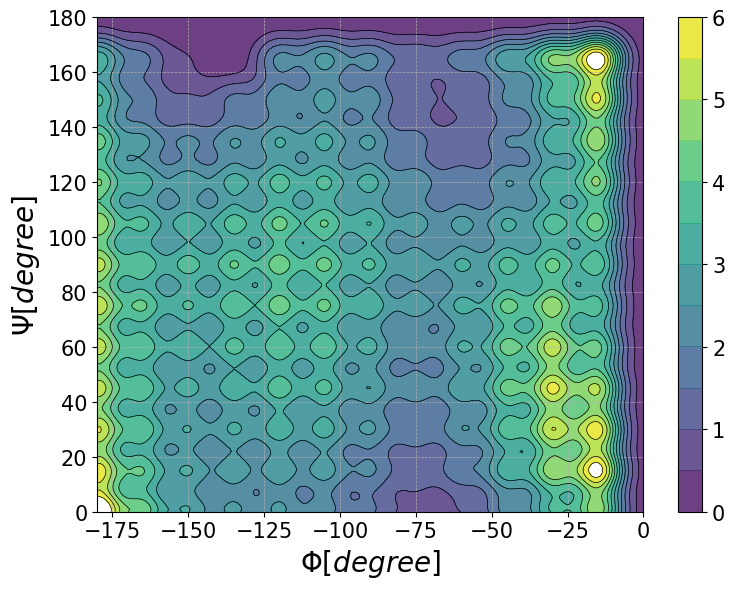

┌ Warning: `getindex(f::Figure, x)` is deprecated, use `getproperty(f, x)` instead.
│   caller = top-level scope at In[17]:10
└ @ Core In[17]:10
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[17]:11
└ @ Core In[17]:11
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[17]:11
└ @ Core In[17]:11
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[17]:14
└ @ Core In[17]:14
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` 

In [17]:
# 図示
fig, ax = subplots(figsize=(8, 6));
meshgrid(x, y) = (repeat(x', length(y), 1), repeat(y, 1, length(x)));
grid_x = -180:1:0;
grid_y = 180:-1:0;
X, Y = meshgrid(grid_x, grid_y);
levels = 0:0.5:6.0;
ax[:contour](X, Y, pmf, levels, colors="black", alpha=1.0, linewidths=0.5);
pos = ax[:contourf](X, Y, pmf, levels, alpha=0.8, cmap=get_cmap("viridis")) # colormaps: viridis, plasma, inferno, magma, jet, hsv, terrain
cbar = fig[:colorbar](pos, ax=ax);
cbar[:ax][:tick_params](labelsize=15);
xlabel(L"\Phi [degree]",fontsize=20);
ylabel(L"\Psi [degree]",fontsize=20);

# detailed options (not necessary, just for reference)
ax[:set](xlim=[-180, 0], ylim=[0, 180]);
ax[:tick_params](axis="both", which="major",labelsize=15);
ax[:grid](linestyle="--", linewidth=0.5);
tight_layout();

savefig("free_energy_surface2.png", dpi=350, bbox_inches="tight");